# Assignment3 - Class Activation Map
####                   201716201 이재원 

In [1]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from config_reader import config_reader
import scipy
import math

C:\ProgramData\Anaconda3\envs\py36tf18\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def relu(x): 
    return Activation('relu')(x)

def conv(x, nf, ks, name):
    x1 = Conv2D(nf, (ks, ks), padding='same', name=name)(x)
    return x1

def pooling(x, ks, st, name):
    x = MaxPooling2D((ks, ks), strides=(st, st), name=name)(x)
    return x

def vgg_block(x):
     
    # Block 1
    x = conv(x, 64, 3, "conv1_1")
    x = relu(x)
    x = conv(x, 64, 3, "conv1_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool1_1")

    # Block 2
    x = conv(x, 128, 3, "conv2_1")
    x = relu(x)
    x = conv(x, 128, 3, "conv2_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool2_1")
    
    # Block 3
    x = conv(x, 256, 3, "conv3_1")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_2")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_3")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_4")
    x = relu(x)    
    x = pooling(x, 2, 2, "pool3_1")
    
    # Block 4
    x = conv(x, 512, 3, "conv4_1")
    x = relu(x)    
    x = conv(x, 512, 3, "conv4_2")
    x = relu(x)    
    
    # Additional non vgg layers
    x = conv(x, 256, 3, "conv4_3_CPM")
    x = relu(x)
    x = conv(x, 128, 3, "conv4_4_CPM")
    x = relu(x)
    
    return x

def stage1_block(x, num_p, branch):
    
    # Block 1        
    x = conv(x, 128, 3, "conv5_1_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_2_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_3_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 512, 1, "conv5_4_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, num_p, 1, "conv5_5_CPM_L%d" % branch)
    
    return x

def stageT_block(x, num_p, stage, branch):
        
    # Block 1        
    x = conv(x, 128, 7, "Mconv1_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv2_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv3_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv4_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv5_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 1, "Mconv6_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, num_p, 1, "Mconv7_stage%d_L%d" % (stage, branch))
    
    return x

In [3]:
weights_path = "models/weights.0054-60.41.hdf5" # orginal weights converted from caffe
#weights_path = "training/weights.best.h5" # weights tarined from scratch 

input_shape = (None,None,3)

img_input = Input(shape=input_shape)

stages = 2
#np_branch1 = 38
np_branch2 = 19

img_normalized = Lambda(lambda x: x / 256 - 0.5)(img_input)  # [-0.5, 0.5]

In [4]:
# VGG
stage0_out = vgg_block(img_normalized)

# stage 1
#stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1)
stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2)
x = Concatenate()([stage1_branch2_out, stage0_out])

In [5]:
# stage t >= 2
for sn in range(2, stages + 1):
    #stageT_branch1_out = stageT_block(x, np_branch1, sn, 1)
    stageT_branch2_out = stageT_block(x, np_branch2, sn, 2)
    if (sn < stages):
        x = Concatenate()([stageT_branch2_out, stage0_out])
        

In [6]:
model = Model(img_input, [stageT_branch2_out])

In [7]:
model.load_weights(weights_path)

In [8]:
%matplotlib inline
import cv2
import matplotlib
import pylab as plt
import numpy as np
import util

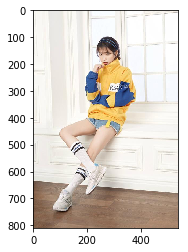

In [9]:
test_image = 'sample_images/IU.jpg'
oriImg = cv2.imread(test_image) # B,G,R order
plt.imshow(oriImg[:,:,[2,1,0]])

In [ ]:
param, model_params = config_reader()

multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_search']]

### part_str = [nose, neck, Rsho, Relb, Rwri, Lsho, Lelb, Lwri, Rhip, Rkne, Rank, Lhip, Lkne, Lank, Leye, Reye, Lear, Rear, pt19]

Input shape: (1, 184, 128, 3)
Input shape: (1, 368, 248, 3)
Input shape: (1, 552, 368, 3)
Input shape: (1, 736, 496, 3)


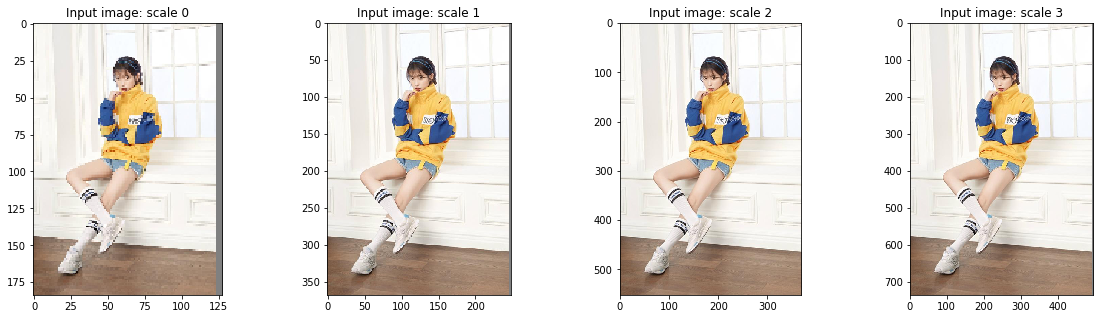

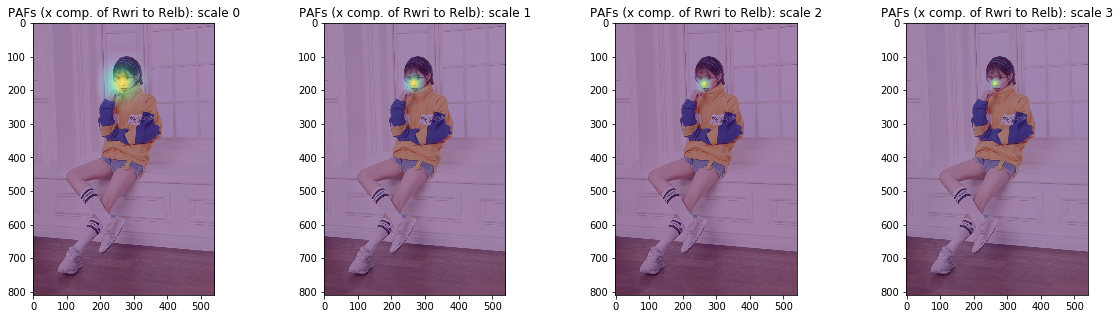

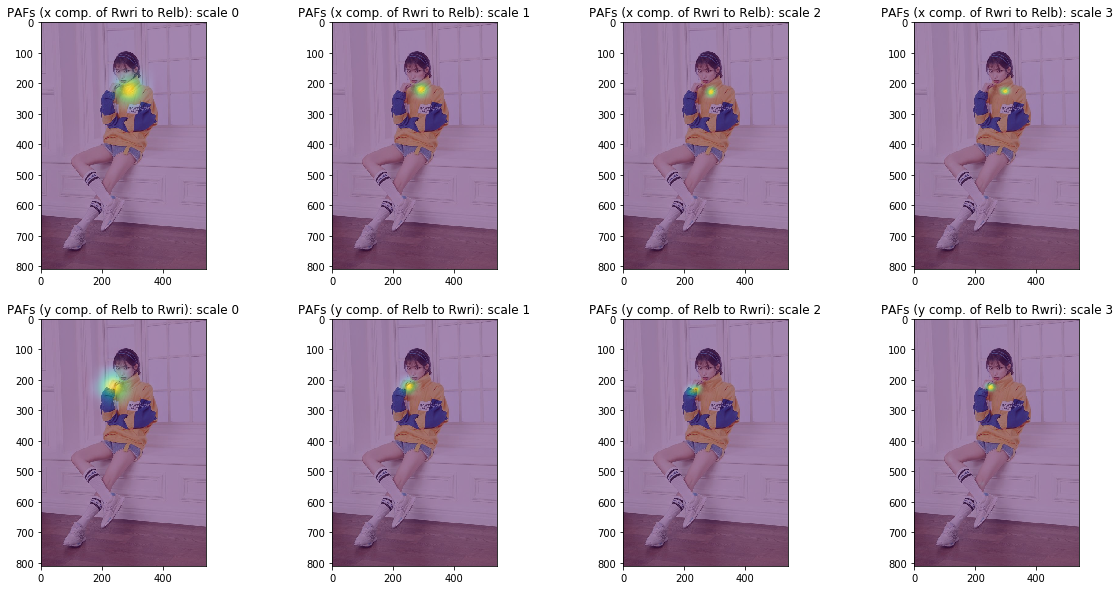

In [16]:
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
# first figure shows padded images
f, axarr = plt.subplots(1, len(multiplier))
f.set_size_inches((20, 5))
# second figure shows heatmaps
f2, axarr2 = plt.subplots(1, len(multiplier))
f2.set_size_inches((20, 5))
# third figure shows PAFs
f3, axarr3 = plt.subplots(2, len(multiplier))
f3.set_size_inches((20, 10))

for m in range(len(multiplier)):
    scale = multiplier[m]
    imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'], model_params['padValue'])        
    axarr[m].imshow(imageToTest_padded[:,:,[2,1,0]])
    axarr[m].set_title('Input image: scale %d' % m)

    input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
    print("Input shape: " + str(input_img.shape))  

    output_blobs = model.predict(input_img)
        
    paf = np.squeeze(output_blobs[0]) # output 0 is PAFs
    paf = cv2.resize(paf, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
    paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    # visualization
    axarr2[m].imshow(oriImg[:,:,[2,1,0]])
    ax2x = axarr2.flat[m].imshow(paf[:,:,0], alpha=.5) # right elbow
    axarr2.flat[m].set_title('PAFs (x comp. of Rwri to Relb): scale %d' % m)
    
    axarr3.flat[m].imshow(oriImg[:,:,[2,1,0]])
    ax3x = axarr3.flat[m].imshow(paf[:,:,1], alpha=.5) # right elbow
    axarr3.flat[m].set_title('PAFs (x comp. of Rwri to Relb): scale %d' % m)
    
    axarr3.flat[len(multiplier) + m].imshow(oriImg[:,:,[2,1,0]])
    ax3y = axarr3.flat[len(multiplier) + m].imshow(paf[:,:,2], alpha=.5) # right wrist
    axarr3.flat[len(multiplier) + m].set_title('PAFs (y comp. of Relb to Rwri): scale %d' % m)
    
    paf_avg = paf_avg + paf / len(multiplier)

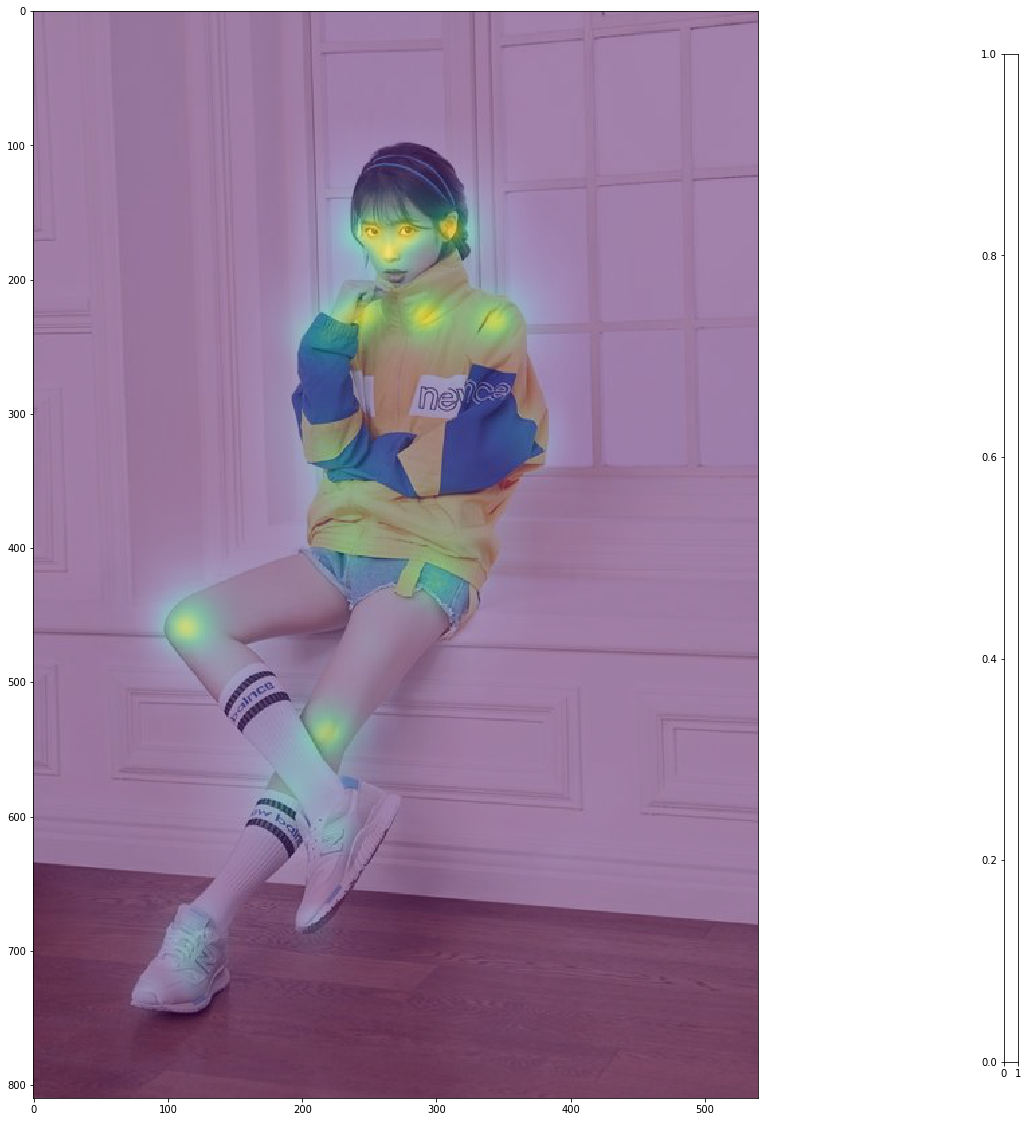

In [14]:
plt.imshow(oriImg[:,:,[2,1,0]])
a = 1- paf_avg[:,:,18]
plt.imshow(a, alpha=.5)
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(ax2, cax=cbar_ax)